#  Counting Rotated Shapes


An example of a multi-layer Convolutional Neural network with a **poisson** loss in a **counting** problem.

For images that can be rotated a single convolution layer is not enough, and we need a model with at least two layers.


## Preliminaries

### Imports

In [1]:
import pickle

import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

import sys


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#
from tensorflow.keras.backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)

sess = tf.Session(config=config)

set_session(sess)  # set this TensorFlow session as the default session for Keras

### Read Data

In [3]:
data_dir="../../data/shapes"
model_dir="../../data/models/tf/Rotated_Color_Shapes"

In [4]:
filename=data_dir+"/rotated_color_shapes.p"
file=open(filename,"rb")
images,data= pickle.load(file)


filename_test=data_dir+"/rotated_color_shapes_test.p"
file_test=open(filename_test,"rb")
images_test,data_test= pickle.load(file_test)  

print(images.shape,data.shape,images_test.shape,data_test.shape)

(10000, 100, 100, 3) (10000,) (10000, 100, 100, 3) (10000,)


In [5]:
data[0]

,colors,shapes,theta,center_x,center_y
0,yellow,rectangle,0.468041,79,59
1,cyan,rectangle,5.808961,62,56
2,orange,rectangle,1.496735,32,40
3,yellow,circle,0.432456,92,30
4,orange,rectangle,5.388134,7,82
5,yellow,triangle,5.914677,33,80
6,cyan,rectangle,5.148180,14,19
7,orange,rectangle,4.057289,52,35
8,cyan,rectangle,0.778599,59,89
9,orange,rectangle,1.512402,80,91


### Generate Labels

In [6]:
colors=["yellow","brown","cyan"]
shapes=["rectangle","circle","triangle"]

In [7]:
k=len(colors)*len(shapes)

In [8]:
df=data[0]
color="red"
shape="rectangle"
len(df[df["colors"]==color]),# & (df['shapes']==shape) ])
len(df[df["shapes"]==shape])

8

In [9]:
def compute_label(df):
    counts=np.zeros((len(colors),len(shapes)),dtype=np.int)
    if df.empty or (df is None):
        return counts
    for i1,color in enumerate(colors):
        for i2,shape in enumerate(shapes):
            counts[i1,i2]=len(df[(df["colors"]==color) & (df['shapes']==shape) ])
            #print (color,shape,counts[i1,i2])
    return counts
compute_labels=np.vectorize(compute_label)

In [10]:
compute_label(data[0])

array([[1, 1, 1],
       [0, 0, 0],
       [3, 0, 0]])

In [11]:
def compute_labels(data):
    labels=[]
    for i1,df in enumerate(data):
        #print(i1)
        labels.append(compute_label(df))
    return np.array(labels)

In [12]:
labels=compute_labels(data)
labels.shape

(10000, 3, 3)

In [13]:
labels_test=compute_labels(data_test)
labels_test.shape

(10000, 3, 3)

In [14]:
labels=labels.reshape(-1,k)
labels_test=labels_test.reshape(-1,k)
print(labels.shape,labels_test.shape)

(10000, 9) (10000, 9)


## Helper Functions

In [105]:
class ReportCallback(keras.callbacks.Callback):
    def __init__(self,frequency,use_val=False):
        self.freq=frequency
        self.use_val=use_val
        self.separator=" || "
        if not(self.use_val):
            self.separator="\n"
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % self.freq ==0):
            train_loss=logs["loss"]
            train_error=logs["count_err"]
            print(f"\t{epoch}: TRAIN Loss {train_loss:.4f},  Err {train_error:.4f}",end=self.separator)
            if self.use_val:
                val_loss=logs["val_loss"]
                val_error=logs["val_count_err"]
                print(f"VAL Loss {val_loss:.4f}, Err {val_error:.4f}")

In [16]:
def count_err(y_true, y_pred):
    return K.sum(K.abs(K.round(y_pred)-y_true),axis=-1)

In [17]:
def count_error(y_pred,y):
    return np.sum(np.abs(np.round(y_pred)-np.round(y)))/len(y)

## Model Selection

### Convolution Only

In [18]:
model0 = keras.Sequential([
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(100, 100)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [20]:
optimizer=tf.train.AdamOptimizer(learning_rate=0.0005)

In [21]:
model0.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [22]:
hist0=model0.fit(images,labels,epochs=1000,validation_split=0.2,verbose=0,callbacks=[ReportCallback(10)])

	0: TRAIN Loss 0.6411,  Err 4.6301 || VAL Loss 0.6052, Err 4.3860
	10: TRAIN Loss 0.5498,  Err 3.9449 || VAL Loss 0.5493, Err 3.9660
	20: TRAIN Loss 0.5185,  Err 3.5642 || VAL Loss 0.5176, Err 3.5945
	30: TRAIN Loss 0.5032,  Err 3.2662 || VAL Loss 0.5068, Err 3.3005
	40: TRAIN Loss 0.4975,  Err 3.1424 || VAL Loss 0.5011, Err 3.2000
	50: TRAIN Loss 0.4953,  Err 3.0888 || VAL Loss 0.4960, Err 3.1605
	60: TRAIN Loss 0.4939,  Err 3.0591 || VAL Loss 0.4981, Err 3.1540
	70: TRAIN Loss 0.4926,  Err 3.0492 || VAL Loss 0.5016, Err 3.3175
	80: TRAIN Loss 0.4905,  Err 3.0017 || VAL Loss 0.4919, Err 3.0685
	90: TRAIN Loss 0.4896,  Err 2.9894 || VAL Loss 0.4892, Err 3.0365
	100: TRAIN Loss 0.4867,  Err 2.9620 || VAL Loss 0.4866, Err 2.9495
	110: TRAIN Loss 0.4848,  Err 2.9441 || VAL Loss 0.4837, Err 2.9665
	120: TRAIN Loss 0.4826,  Err 2.8998 || VAL Loss 0.4840, Err 2.8830
	130: TRAIN Loss 0.4819,  Err 2.8965 || VAL Loss 0.4829, Err 3.0430
	140: TRAIN Loss 0.4798,  Err 2.8678 || VAL Loss 0.4802, Er

###  Two layers on Convolution

In [23]:
model1 = keras.Sequential([
    
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(50, 50)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [24]:
model1.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [25]:
hist1=model1.fit(images,labels,epochs=1000,validation_split=0.2,verbose=0,callbacks=[ReportCallback(10)])

	0: TRAIN Loss 0.6067,  Err 4.4028 || VAL Loss 0.5805, Err 4.2350
	10: TRAIN Loss 0.4869,  Err 2.9297 || VAL Loss 0.4863, Err 2.9215
	20: TRAIN Loss 0.4672,  Err 2.6831 || VAL Loss 0.4601, Err 2.6210
	30: TRAIN Loss 0.4308,  Err 2.0385 || VAL Loss 0.4278, Err 2.3050
	40: TRAIN Loss 0.4209,  Err 1.7837 || VAL Loss 0.4202, Err 1.9085
	50: TRAIN Loss 0.4170,  Err 1.6433 || VAL Loss 0.4215, Err 1.6835
	60: TRAIN Loss 0.4154,  Err 1.5735 || VAL Loss 0.4110, Err 1.4415
	70: TRAIN Loss 0.4145,  Err 1.5263 || VAL Loss 0.4144, Err 1.5215
	80: TRAIN Loss 0.4126,  Err 1.4712 || VAL Loss 0.4096, Err 1.5280
	90: TRAIN Loss 0.4110,  Err 1.4514 || VAL Loss 0.4157, Err 1.5305
	100: TRAIN Loss 0.4095,  Err 1.4039 || VAL Loss 0.4088, Err 1.4355
	110: TRAIN Loss 0.4102,  Err 1.4184 || VAL Loss 0.4140, Err 1.4230
	120: TRAIN Loss 0.4087,  Err 1.3760 || VAL Loss 0.4274, Err 1.7965
	130: TRAIN Loss 0.4082,  Err 1.3567 || VAL Loss 0.4071, Err 1.3320
	140: TRAIN Loss 0.4098,  Err 1.3927 || VAL Loss 0.4120, Er

### 1 Convolutional Layer plus one Dense Layers

In [41]:

model2 = keras.Sequential([
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(100, 100)),
   
    # Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [42]:
model2.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [43]:
hist2=model2.fit(images,labels,epochs=1000,validation_split=0.2,verbose=0,callbacks=[ReportCallback(10)])

	0: TRAIN Loss 0.5949,  Err 4.2625 || VAL Loss 0.5707, Err 4.0475
	10: TRAIN Loss 0.4708,  Err 2.8279 || VAL Loss 0.4764, Err 2.9455
	20: TRAIN Loss 0.4527,  Err 2.6575 || VAL Loss 0.4534, Err 2.7185
	30: TRAIN Loss 0.4435,  Err 2.5711 || VAL Loss 0.4472, Err 2.6540
	40: TRAIN Loss 0.4365,  Err 2.4669 || VAL Loss 0.4357, Err 2.4785
	50: TRAIN Loss 0.4312,  Err 2.3796 || VAL Loss 0.4306, Err 2.3655
	60: TRAIN Loss 0.4256,  Err 2.2652 || VAL Loss 0.4269, Err 2.2940
	70: TRAIN Loss 0.4232,  Err 2.2434 || VAL Loss 0.4248, Err 2.2595
	80: TRAIN Loss 0.4200,  Err 2.2219 || VAL Loss 0.4184, Err 2.1790
	90: TRAIN Loss 0.4165,  Err 2.1724 || VAL Loss 0.4230, Err 2.3960
	100: TRAIN Loss 0.4128,  Err 2.1066 || VAL Loss 0.4142, Err 2.1520
	110: TRAIN Loss 0.4115,  Err 2.0961 || VAL Loss 0.4121, Err 2.1515
	120: TRAIN Loss 0.4104,  Err 2.0915 || VAL Loss 0.4095, Err 2.0755
	130: TRAIN Loss 0.4082,  Err 2.0519 || VAL Loss 0.4084, Err 2.0585
	140: TRAIN Loss 0.4064,  Err 2.0387 || VAL Loss 0.4074, Er

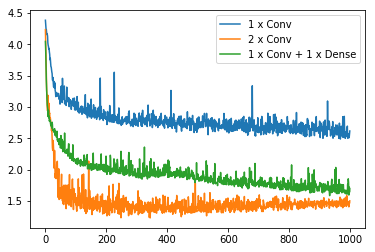

In [44]:
plt.plot(hist0.history["val_count_err"],label="1 x Conv")
plt.plot(hist1.history["val_count_err"],label="2 x Conv")
plt.plot(hist2.history["val_count_err"],label="1 x Conv + 1 x Dense")
plt.legend()

### Two Convolution layers plus Dense Layer

In [60]:


model3 = keras.Sequential([
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu',padding="same"),
     keras.layers.AveragePooling2D(pool_size=(50, 50)),
    # Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [61]:
model3.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [63]:
hist3=model3.fit(images,labels,epochs=1000,validation_split=0.2,verbose=0,callbacks=[ReportCallback(10)])

	0: TRAIN Loss 0.5988,  Err 4.2284 || VAL Loss 0.5628, Err 3.9790
	10: TRAIN Loss 0.3972,  Err 1.7953 || VAL Loss 0.3925, Err 1.6610
	20: TRAIN Loss 0.3581,  Err 1.2243 || VAL Loss 0.3556, Err 1.2290
	30: TRAIN Loss 0.3254,  Err 0.6286 || VAL Loss 0.3223, Err 0.6325
	40: TRAIN Loss 0.3108,  Err 0.4589 || VAL Loss 0.3067, Err 0.4360
	50: TRAIN Loss 0.2998,  Err 0.3039 || VAL Loss 0.2968, Err 0.3150
	60: TRAIN Loss 0.2925,  Err 0.2546 || VAL Loss 0.2953, Err 0.5150
	70: TRAIN Loss 0.2906,  Err 0.2490 || VAL Loss 0.2889, Err 0.2915
	80: TRAIN Loss 0.2872,  Err 0.2018 || VAL Loss 0.2868, Err 0.2375
	90: TRAIN Loss 0.2863,  Err 0.1709 || VAL Loss 0.2870, Err 0.2085
	100: TRAIN Loss 0.2859,  Err 0.1686 || VAL Loss 0.2888, Err 0.3315
	110: TRAIN Loss 0.2859,  Err 0.1732 || VAL Loss 0.2823, Err 0.1115
	120: TRAIN Loss 0.2847,  Err 0.1354 || VAL Loss 0.2808, Err 0.0950
	130: TRAIN Loss 0.2844,  Err 0.1348 || VAL Loss 0.2803, Err 0.0695
	140: TRAIN Loss 0.2844,  Err 0.1354 || VAL Loss 0.2802, Er

In [64]:
Y_pred=model3.predict(images)

In [65]:

count_error(Y_pred,labels)

0.0016

yellow rectangle 0 0.0
yellow circle 1 1.0
yellow triangle 2 2.0
brown rectangle 0 0.0
brown circle 0 0.0
brown triangle 0 0.0
cyan rectangle 0 0.0
cyan circle 2 2.0
cyan triangle 2 2.0


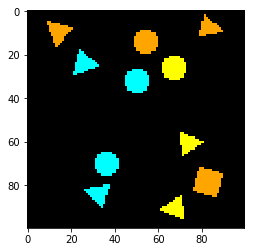

In [66]:
idx=104
for i1,color in enumerate(colors):
        for i2,shape in enumerate(shapes):
            k=i1*len(shapes)+i2
            print(color,shape,labels[idx,k],round(Y_pred[idx,k]))
plt.imshow(images[idx])

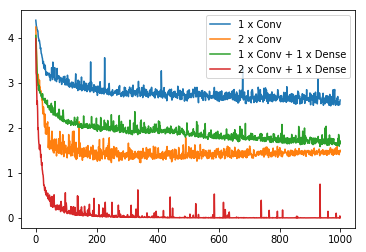

In [67]:
plt.plot(hist0.history["val_count_err"],label="1 x Conv")
plt.plot(hist1.history["val_count_err"],label="2 x Conv")
plt.plot(hist2.history["val_count_err"],label="1 x Conv + 1 x Dense")
plt.plot(hist3.history["val_count_err"],label="2 x Conv + 1 x Dense")
plt.legend()

## Model Test

In [109]:
model = keras.Sequential([
    
    # Convolutional Layers
    keras.layers.Conv2D(32, (3, 3),input_shape=(100,100,3), activation='relu',padding="same"),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu',padding="same"),
     keras.layers.AveragePooling2D(pool_size=(50, 50)),
    # Dense Layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(9, kernel_initializer="zeros",activation=None),
    keras.layers.Lambda(lambda x: K.exp(x))
])

In [110]:
model.compile(optimizer=optimizer, 
              loss='poisson',
              metrics=[count_err])

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
average_pooling2d_25 (Averag (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
average_pooling2d_26 (Averag (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_27 (Dense)             (None, 9)                 585       
__________

In [115]:
hist=model.fit(images,labels,epochs=1000,verbose=0,callbacks=[ReportCallback(10,False)])

	0: TRAIN Loss 0.2777,  Err 0.0020
	10: TRAIN Loss 0.2777,  Err 0.0021
	20: TRAIN Loss 0.2780,  Err 0.0079
	30: TRAIN Loss 0.2777,  Err 0.0015
	40: TRAIN Loss 0.2779,  Err 0.0050
	50: TRAIN Loss 0.2777,  Err 0.0014
	60: TRAIN Loss 0.2825,  Err 0.0757
	70: TRAIN Loss 0.2778,  Err 0.0024
	80: TRAIN Loss 0.2778,  Err 0.0030
	90: TRAIN Loss 0.2786,  Err 0.0247
	100: TRAIN Loss 0.2777,  Err 0.0017
	110: TRAIN Loss 0.2777,  Err 0.0020
	120: TRAIN Loss 0.2777,  Err 0.0019
	130: TRAIN Loss 0.2778,  Err 0.0028
	140: TRAIN Loss 0.2777,  Err 0.0018
	150: TRAIN Loss 0.2777,  Err 0.0019
	160: TRAIN Loss 0.2777,  Err 0.0016
	170: TRAIN Loss 0.2777,  Err 0.0018
	180: TRAIN Loss 0.2777,  Err 0.0018
	190: TRAIN Loss 0.2779,  Err 0.0070
	200: TRAIN Loss 0.2777,  Err 0.0015
	210: TRAIN Loss 0.2781,  Err 0.0077
	220: TRAIN Loss 0.2777,  Err 0.0012
	230: TRAIN Loss 0.2776,  Err 0.0012
	240: TRAIN Loss 0.2776,  Err 0.0007
	250: TRAIN Loss 0.2776,  Err 0.0021
	260: TRAIN Loss 0.2776,  Err 0.0007
	270: TRAIN 

In [116]:
Y_pred=model.predict(images_test)
count_error(Y_pred,labels_test)

0.0028

yellow rectangle 5 5.0
yellow circle 2 2.0
yellow triangle 1 1.0
brown rectangle 0 0.0
brown circle 0 0.0
brown triangle 0 0.0
cyan rectangle 1 1.0
cyan circle 2 2.0
cyan triangle 0 0.0


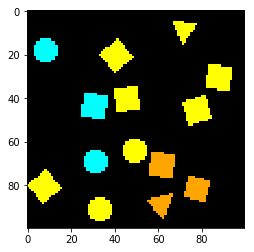

In [120]:
idx=201
for i1,color in enumerate(colors):
        for i2,shape in enumerate(shapes):
            k=i1*len(shapes)+i2
            print(color,shape,labels_test[idx,k],round(Y_pred[idx,k]))
plt.imshow(images_test[idx])